In [143]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [144]:
item_category_df = pd.read_csv("data/item_categories.csv")
items_df = pd.read_csv("data/items.csv")
shops_df = pd.read_csv("data/shops.csv")
sample_df = pd.read_csv("data/sample_submission.csv")
train_df = pd.read_csv("data/sales_train_v2.csv")
test_df = pd.read_csv("data/test.csv")

In [145]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [146]:
f = lambda x: x.split(".")
train_df['date'] =list(map(f, train_df['date']))

In [147]:
f = lambda x: x[1]
train_df['month'] =list(map(f, train_df['date']))

In [148]:
f = lambda x: x[2]
train_df['year'] =list(map(f, train_df['date']))

In [149]:
train_df = train_df.drop(['date'],axis=1)

In [150]:
train_df.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
0,0,59,22154,999.00,1.0,01,2013
1,0,25,2552,899.00,1.0,01,2013
2,0,25,2552,899.00,-1.0,01,2013
3,0,25,2554,1709.05,1.0,01,2013
4,0,25,2555,1099.00,1.0,01,2013


In [151]:
icd_value = set(train_df["item_cnt_day"])
icd_value
# train data의 item_cnt_day의 unique value들.
# -가 붙으면 환불(Refund) 기록
# -22와 -16, -9는 불연속적인 term을 보임, 일어난 빈도수도 34개월 데이터에서 1번
# 1000과 2169는 불연속적인 noise term. 일어난 빈도수도 34개월 데이터에서 1번
## 위의 빈도수 자료는 최하단 히스토그램으로 첨부하겠음.

{-22.0,
 -16.0,
 -9.0,
 -6.0,
 -5.0,
 -4.0,
 -3.0,
 -2.0,
 -1.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 121.0,
 124.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 138.0,
 1

In [152]:
train_df["item_cnt_day"].mean()

1.242640885140891

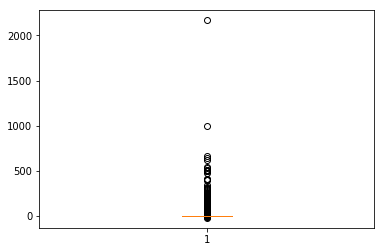

In [153]:
plt.boxplot(train_df["item_cnt_day"])
plt.show()
# Boxplot으로 나타낸 item_cnt_day의 값들의 빈도수. 이상치가 한눈에 들어온다.
# 평균을 계산하면 1.24로 1근방 이외의 데이터를 제외하기엔 너무 많은 row의 종류를
## 지우게 되기 때문에 아래와 같은 전처리 과정을 거치고자 한다.

In [154]:
more_than_thousand = train_df["item_cnt_day"].where(train_df["item_cnt_day"]>999)
more_than_thousand.dropna(how='all').head()
# 불연속적인 noise term 제거를 위한 index 확인 (1000, 2169)

2326930    1000.0
2909818    2169.0
Name: item_cnt_day, dtype: float64

In [155]:
below_ten = train_df["item_cnt_day"].where(train_df["item_cnt_day"] <-8)
below_ten.dropna(how='all').head()
# 불연속적인 refund term 제거를 위한 index 확인 (-22, -16,-9)

1057907   -22.0
1835454   -16.0
2048519    -9.0
Name: item_cnt_day, dtype: float64

In [156]:
train_new = train_df.drop([2326930,2909818,1057907,1835454,2048519])
# 불연속적인 noise와 refund term 제거 실시

In [157]:
train_new.shape
# 2935849개의 row instance에서 2935844(5만큼 감소)로 줄어 든 것을 check

(2935844, 7)

In [221]:
icd_frequency = train_df.groupby("item_cnt_day")["month"].count()
icd_frequency
# item_cnt_day의 각 값들의 빈도수를 계산

item_cnt_day
-22.0            1
-16.0            1
-9.0             1
-6.0             2
-5.0             4
-4.0             3
-3.0            14
-2.0            78
-1.0          7252
 1.0       2629372
 2.0        194201
 3.0         47350
 4.0         19685
 5.0         10474
 6.0          6338
 7.0          4057
 8.0          2903
 9.0          2177
 10.0         1820
 11.0         1263
 12.0         1083
 13.0          918
 14.0          716
 15.0          638
 16.0          544
 17.0          438
 18.0          391
 19.0          347
 20.0          364
 21.0          290
            ...   
 230.0           1
 231.0           1
 240.0           1
 242.0           1
 251.0           1
 255.0           1
 264.0           1
 288.0           1
 299.0           1
 300.0           1
 313.0           2
 325.0           1
 343.0           1
 401.0           2
 405.0           1
 412.0           1
 480.0           1
 500.0           2
 501.0           1
 502.0           1
 504.0           1

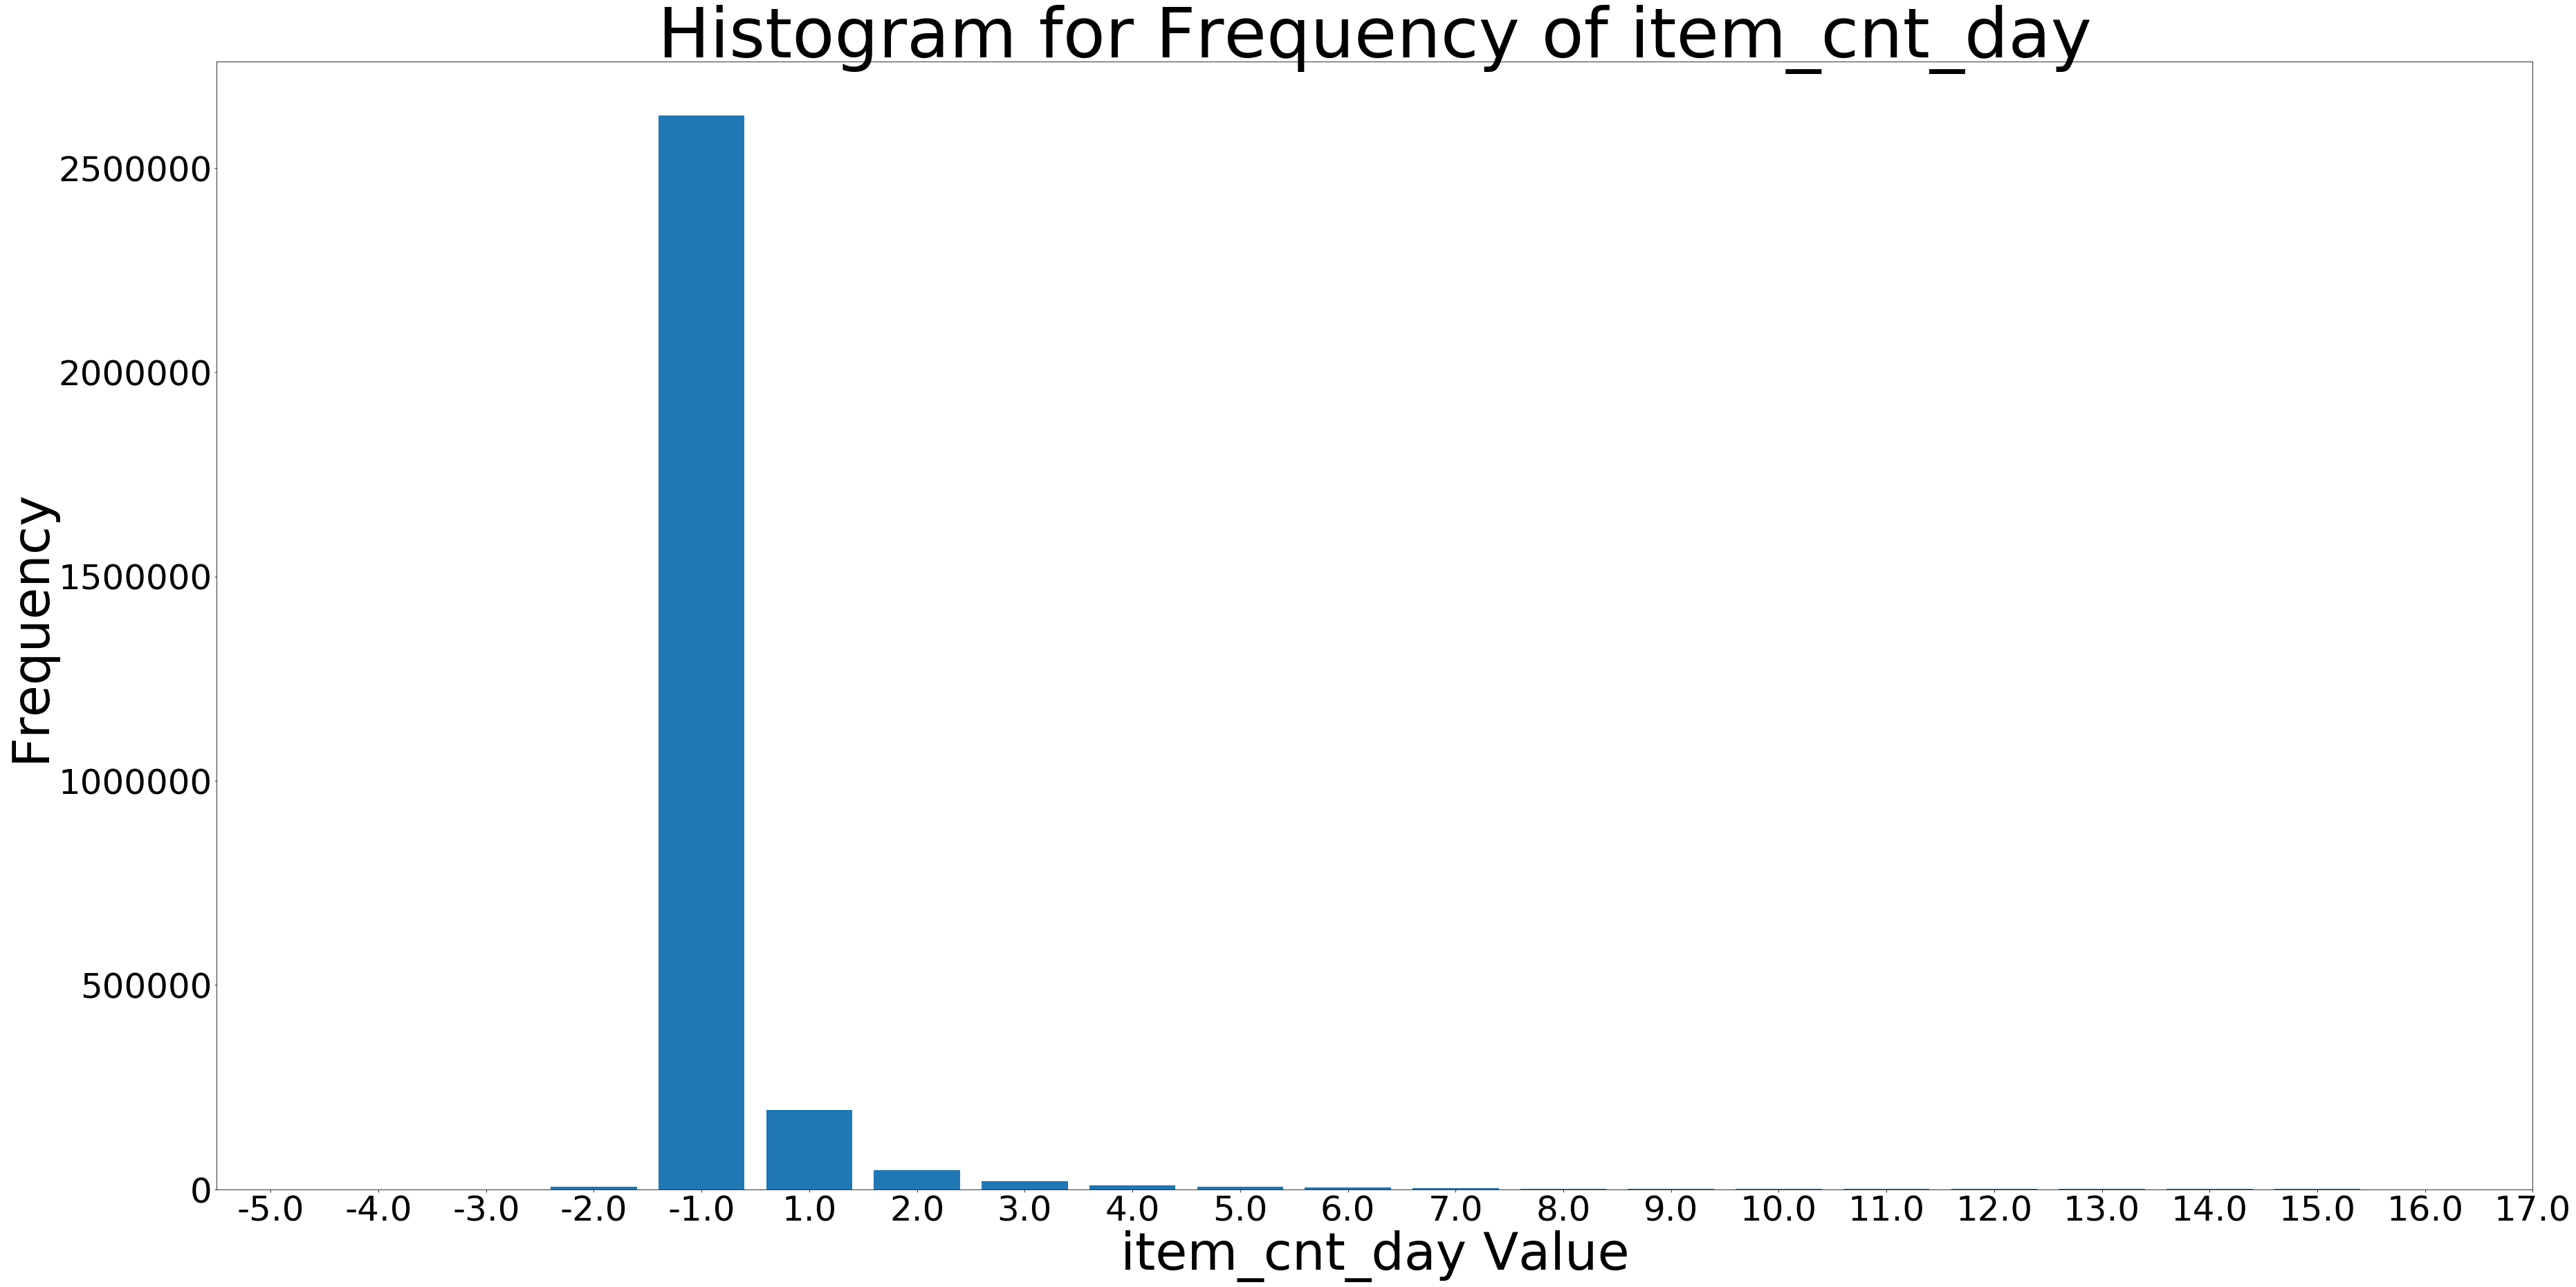

In [223]:
fig = plt.figure()
fig.set_size_inches(60,30)
X=np.arange(198)
plt.bar(X+0, icd_frequency)
plt.xticks(X+1,icd_frequency.index,size=50)
plt.yticks(size=50)
plt.xlim(4.5,26)
plt.title("Histogram for Frequency of item_cnt_day",size=100)
plt.xlabel("item_cnt_day Value", size=75)
plt.ylabel("Frequency", size=75)
plt.show()

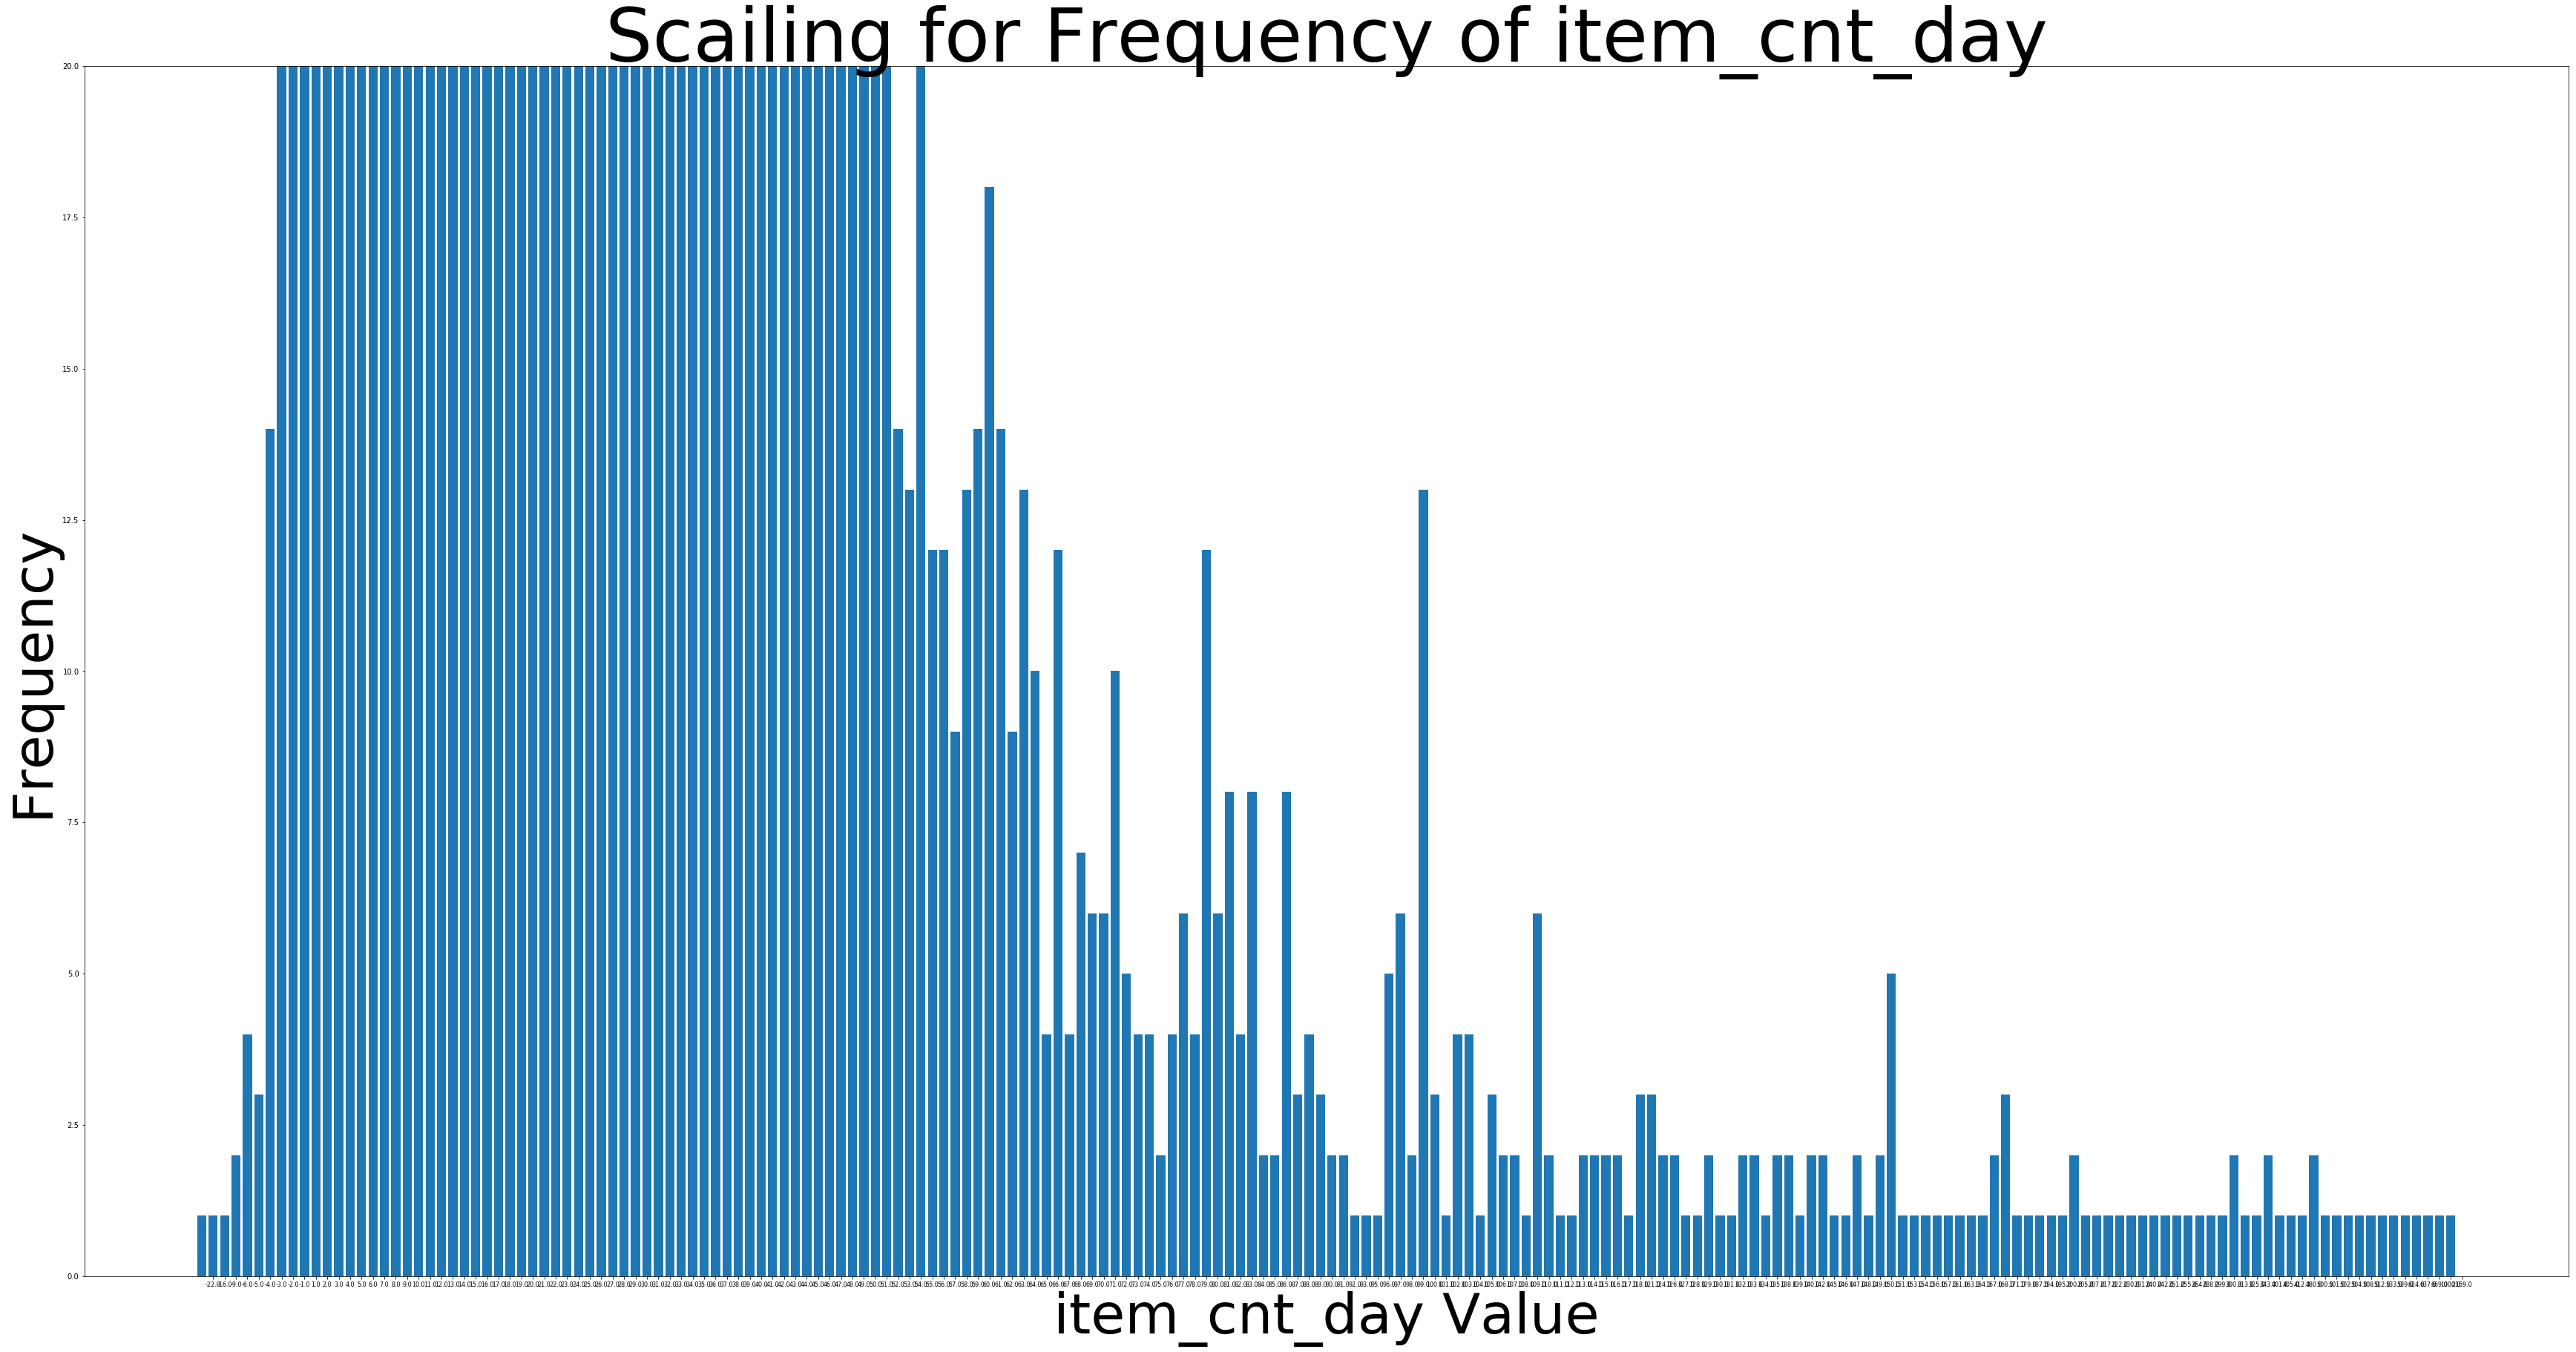

In [224]:
fig = plt.figure()
fig.set_size_inches(60,30)
X=np.arange(198)
plt.bar(X+0, icd_frequency)
plt.xticks(X+1,icd_frequency.index,size=8)
plt.yticks(size=10)
# plt.xlim(4.5,26)
plt.ylim(0,20)
plt.title("Scailing for Frequency of item_cnt_day",size=100)
plt.xlabel("item_cnt_day Value", size=75)
plt.ylabel("Frequency", size=75)
plt.show()

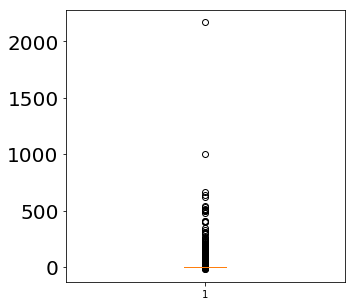

In [218]:
fig = plt.figure()
fig.set_size_inches(5,5)
plt.boxplot(train_df["item_cnt_day"])
plt.yticks(size=20)
plt.show()
# noise 제거 전

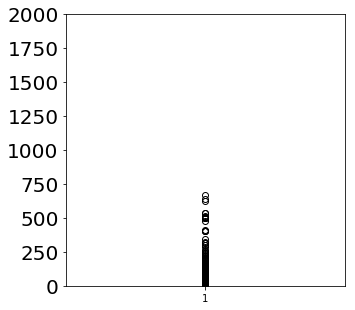

In [217]:
fig = plt.figure()
fig.set_size_inches(5,5)
plt.boxplot(train_new["item_cnt_day"])
plt.yticks(size=20)
plt.ylim(0,2000)
plt.show()
# noise 제거 후
## 큰 차이는 없어보인다

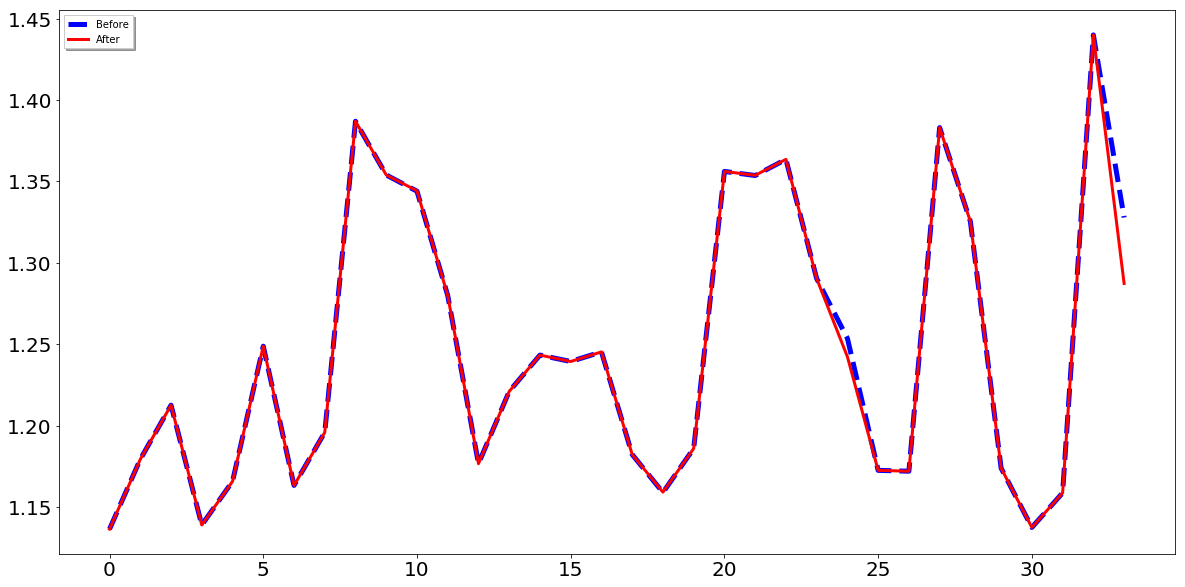

In [220]:
df_mean = train_df.groupby("date_block_num")["item_cnt_day"].mean()
new_mean = train_new.groupby("date_block_num")["item_cnt_day"].mean()
fig = plt.figure()
fig.set_size_inches(20,10)
Y=np.arange(34)
plt.plot(Y, df_mean, linewidth=5, color="b", linestyle="dashed", label="Before")
plt.plot(Y, new_mean, linewidth=3, color="r", label="After")
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(shadow=True, fancybox=False, loc="upper left")
plt.show()

In [ ]:
dfgs